In [3]:
import sys, os
import numpy as np
import glob
import pickle
import cv2
import matplotlib.pyplot as plt
import json
import math
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [4]:
def get_gps(json_path, video_filename):
    with open(json_path) as data_file:    
        data = json.load(data_file)
    
    seg = [x for x in data['segments'] if x['filename']==video_filename]
    assert(len(seg)==1)
    seg = seg[0]
    locs = seg['locations']
    loc2nparray = lambda locs, key: np.array([x[key] for x in locs]).ravel()
    
    res = {}
    bad_video_c = 0
    bad_video_t = 0
    bad_video_same = 0
    for ifile, f in enumerate(locs):
        if int(f['course']) == -1 or int(f['speed']) == -1:
            bad_video_c += 1   # Changed for interpolation
            if bad_video_c >= 3:
                break
        if ifile != 0:
            if int(f['timestamp'])-prev_t > 1100:
                bad_video_t = 1
                break
            if abs(int(f['timestamp']) - int(prev_t)) < 1:
                bad_video_same = 1
                break
        prev_t = f['timestamp']
    if bad_video_c >= 3:
        print('This is a bad video because course or speed is -1', json_path, video_filename)
        return None
    if bad_video_t:
        print('This is a bad video because time sample not uniform', json_path, video_filename)
        return None
    if len(locs)==0:
        print('This is a bad video because no location data available', json_path, video_filename)
        return None
    if bad_video_same:
        print('This is a bad video because same timestamps', json_path, video_filename)
        return None
    
    for key in locs[0].keys():
        res[key]=loc2nparray(locs, key)

    # add the starting time point and ending time point as well
    res['startTime'] = seg['startTime']
    res['endTime'] = seg['endTime']
    
    if res['timestamp'][0] - res['startTime'] > 2000:
        print('This is bad video because starting time too far ahead', json_path, video_filename)
        return None

    if res['endTime'] - res['timestamp'][-1] > 2000:
        print('This is bad video because ending time too far ahead', json_path, video_filename)
        return None

    return res

In [5]:
def fill_missing_speeds_and_courses(values, show_warning):
    l = len(values)
    for i in range(l):
        if values[i] == -1:
            if show_warning:
                print("Warning: course==-1 appears, previous computation might not be reliable")
            if i == (l-1):
                values[i] = values[i-1]
            else:
                if values[i+1] == -1:
                    return None
                values[i] = values[i+1]
    return values

In [6]:
def get_interpolated_speed_xy(res, hz=15):     
    def vec(speed, course):
        t = math.radians(course)
        return np.array([math.sin(t)*speed, math.cos(t)*speed])
    
    course = res['course']
    speed0 = res['speed']
    # first convert to speed vecs
    l=len(course)
    speed = np.zeros((l, 2), dtype = np.float32)
    for i in range(l):
        # interpolate when the number of missing speed is small
        speed0 = fill_missing_speeds_and_courses(speed0, False)
        course = fill_missing_speeds_and_courses(course, True)
        if (speed0 is None) or (course is None):
            return None

        speed[i,:] = vec(speed0[i], course[i])

    tot_ms = res['endTime'] - res['startTime']
    # total number of output
    nout = tot_ms * hz // 1000
    out = np.zeros((nout, 2), dtype=np.float32)
    
    # if time is t second, there should be t+1 points
    last_start = 0
    ts = res['timestamp']
    for i in range(nout):
        # convert to ms timestamp
        timenow = i * 1000.0 / hz + res['startTime']  
        
        while (last_start+1 < len(ts)) and (ts[last_start+1] < timenow):
            last_start += 1
 
        if last_start+1 == len(ts):                    
            out[i, :] = speed[last_start, :]           
        elif timenow <= ts[0]:
            out[i, :] = speed[0, :]
        else:
            time1 = timenow - ts[last_start]
            time2 = ts[last_start+1] - timenow
            r1 = time2 / (time1 + time2)
            r2 = time1 / (time1 + time2)
            inter = r1*speed[last_start, :] + r2*speed[last_start+1, :]
            out[i, :] = inter
    return out

In [7]:
def get_interpolated_speed(json_path, video_filename, hz):
    res = get_gps(json_path, video_filename)
    if res is None:
        return None
    out = get_interpolated_speed_xy(res, hz)
    return out

In [8]:
def gps_to_loc(speed, hz):
    l = len(speed)
    x_start = 0
    y_start = 0
    x = [x_start]
    y = [y_start]
    dtime = 1.0/hz
    for i in range(l-1):
        x.append(x[i]+dtime*speed[i][0])
        y.append(y[i]+dtime*speed[i][1])
        
    return np.array(x),np.array(y)

In [9]:
def fit_plane(T):
    l = len(T)
    T = np.array(T).T
    plane = np.linalg.svd(T)
    #print(plane[0])
    plane = plane[0][:,2]
    print(plane)
    
    a = np.ones([1,l]) 
    new_T = np.concatenate((T,a), axis = 0)
    new_plane = np.linalg.svd(new_T)
    new_plane = new_plane[0][:,2]
    print(new_plane)
    return plane

In [10]:
def compute_R(vec_1, vec_2):
    assert(np.linalg.norm(vec_1) == 1)
    assert(np.linalg.norm(vec_2) == 1)
    cross_product = np.cross(vec_1, vec_2)
    inner_product = np.inner(vec_1, vec_2)
    sine = np.linalg.norm(cross_product)
    cos  = inner_product
    v = cross_product
    v_cross = np.array([[0,-v[2],v[1]],[v[2],0,-v[0]],[-v[1],v[0],0]])
   
    R = np.eye(3) + v_cross + v_cross.dot(v_cross)*(1-cos)/(sine**2)
    return R

In [68]:
def visLoc(locs, label="NotSet"):
    axis=lambda i: [loc[i] for loc in locs]
    plt.plot(axis(0), axis(1), 'ro')
    #print(axis(0)[204:208])
    #print(axis(1)[204:208])
    #plt.plot(locs[:,0],locs[:,1])
    plt.title("Moving paths from " + label)
    plt.xlabel("West -- East")
    plt.ylabel("South -- North")
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [12]:
def camera_motion(camera_path,loc):
    R = []
    T = []
    Name = []
    l = loc.shape[1]
    with open(camera_path) as f:
        content = json.load(f)
    content = content[0]['shots']
    #print(content)
    for i in range(l):
        key = str(i+1).zfill(4)+'.jpg'
        if content.has_key(key):
            r = cv2.Rodrigues(np.array(content[key]['rotation']))
            t = np.array(content[key]['translation'])
            R.append(r[0])
            T.append(t)
            Name.append(key)
    return R, T, Name

In [13]:
def camera_pose(R,T):
    P = []
    l = len(T)
    for i in range(l):
        pose = -np.array(R[i]).T.dot(T[i])
        P.append(pose)
    return P

In [14]:
def compute_scale(T, Name, loc):
    scale = []
    loc = loc.T
    for i in range(0,len(T)-1):
        name_1 = int(Name[i].split('.')[0])
        name_2 = int(Name[i+1].split('.')[0])
        #print(i)
        #print(name_1)
        #print(name_2)
        dist_cam = T[i+1] - T[i]
        dist_loc = loc[name_2 - 1] - loc[name_1 - 1] # gps
        print(dist_cam)
        print(dist_loc)
        scale.append(np.linalg.norm(dist_loc)/np.linalg.norm(dist_cam))
    scale = np.array(scale)
    index = np.argsort(scale)
    scale = scale[index[5:-5]]
    return scale

In [26]:
def align(loc, P, scale):
    loc_scale = loc*(1/scale)
    loc_scale = loc_scale.T
    loc_scale = loc_scale - loc_scale[0,:]
    T_ = np.array(P).T
    T_ = T_.T
    T_ = T_ - T_[0,:]
    return loc_scale, T_

In [66]:
def rotate_gps(loc_scale, T_, Name):
    l = T_.shape[0]
    
    for i in range(1):
        name_1 = int(Name[i].split('.')[0])
        name_2 = int(Name[i+1].split('.')[0])
        
        vec_target = T_[i+1] - T_[i]
        vec_source = loc_scale[name_2 - 1] - loc_scale[name_1 - 1]
        vec_target = vec_target[0:2]/np.linalg.norm(vec_target[0:2])
        vec_source = vec_source[0:2]/np.linalg.norm(vec_source[0:2])
        
        cos = np.inner(vec_target, vec_source)
        cross_product = np.cross(vec_source, vec_target)
        sine = np.linalg.norm(cross_product)
        R_2D = np.array([[cos,-sine],[sine, cos]])
        new_pos = R_2D.dot(loc_scale[:,0:2].T)
        loc_scale_new = loc_scale
        loc_scale_new[:,0:2] = new_pos.T
    return loc_scale_new

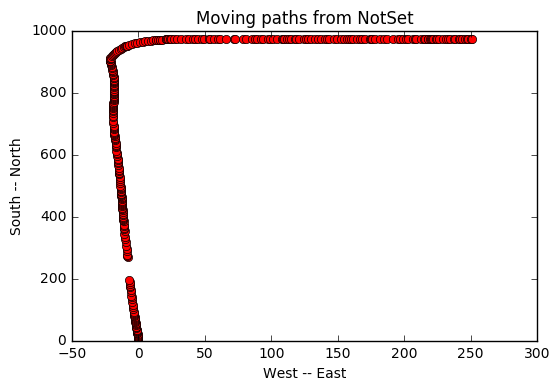

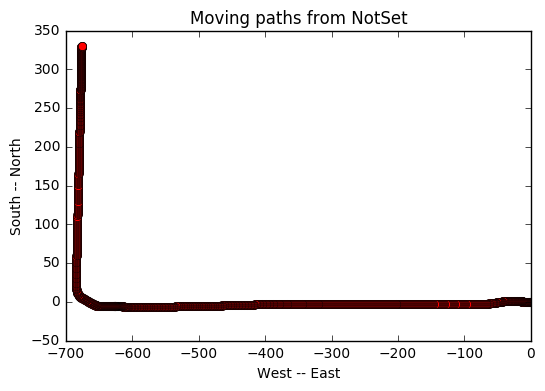

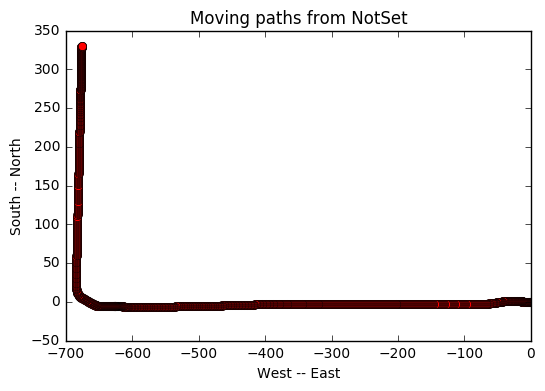

In [69]:
if __name__ == '__main__':
    path_to_camera = '/data/hxu/OpenSfM/data/47fa6807-46b4-4121-848b-beb291cc2d60/reconstruction.json'
    if 1 != True:
        path_to_gps = '/data/nx-bdd-20160929/ride/5502d0bfb3f65da76a82fb159ce75e21/ride.json'
        path_to_video = '47fa6807-46b4-4121-848b-beb291cc2d60.mov'
        
        content = get_gps(path_to_gps, path_to_video)

        content['course']=fill_missing_speeds_and_courses(content['course'],1)
        out = get_interpolated_speed(path_to_gps, path_to_video, 30)

        x,y = gps_to_loc(out, 30)

        loc = np.array([x,y])

        #
        Z = np.expand_dims(np.zeros_like(x),0)

        loc = np.concatenate((loc,Z),axis=0)
        #### here we want to 
        R, T, Name = camera_motion(path_to_camera,loc)
        P = camera_pose(R,T)
        T_ = np.array(P).T
        
        
        
        #visLoc(np.array(T))
        #w = R.dot(np.array(T).T)
        #print(w.T)
        #visLoc(w.T)
        #print(path_to_camera)
        #pln = fit_plane(T)
        #R_proj = compute_R(pln,np.array([0,0,1]))
        #T_ = R_proj.dot(np.array(T).T)
        #T_ = T_.T
        visLoc(T_.T)
        scale = compute_scale(P, Name, loc)
        scale = np.mean(scale)
        print(scale)

    loc_scale, T_ = align(loc, P, scale)
    loc_scale_new = rotate_gps(loc_scale, T_, Name)
    visLoc(T_[:])
    visLoc(loc_scale_new)
    visLoc(loc_scale)

In [63]:
#print(Name[45:47])
#print(loc_scale[124:130,:])
#print(P[44:47])
#print(np.linalg.norm([1,2,3]))
#np.array([1,2,3])-2
#T_ - T_[0,:]#np.array([100000,1000000,10000000])
np.flip([1,2])

AttributeError: 'module' object has no attribute 'flip'

In [29]:
#ax = fig.add_subplot(111, projection='3d')
    #plt.gca().set_aspect('equal', adjustable='box')
    #ax.plot3D(xs=T_[0,:],ys=T_[1,:],zs=0)
    #plt.figure()
    #plt.plot(w[1,:],'ro')

[ -40.10186003 -695.74382407   -1.00583086]
[ -40.15307993 -693.08868705   -0.86590044]
[ -40.27034678 -688.11358691   -0.70883913]
[ -4.04179665e+01  -6.85040238e+02  -5.61341346e-01]
[ -4.04313958e+01  -6.83416782e+02  -6.74605210e-01]
[ -40.47466159 -681.45231002   -0.70267146]
[ -4.06465955e+01  -6.77914275e+02  -6.47078965e-01]
[ -4.07625442e+01  -6.75389816e+02  -6.05778325e-01]
[ -4.08646701e+01  -6.73153630e+02  -5.81407802e-01]
[ -4.09778420e+01  -6.70728130e+02  -5.97628670e-01]
[ -4.11033210e+01  -6.68331243e+02  -5.67771367e-01]
[ -4.12396379e+01  -6.65553580e+02  -4.85689939e-01]
[ -4.12625455e+01  -6.64591956e+02  -5.58358946e-01]
[ -4.13378673e+01  -6.63213154e+02  -5.13147580e-01]
[ -4.14251101e+01  -6.60622597e+02  -5.40938900e-01]
[ -4.15603596e+01  -6.56435886e+02  -4.96491178e-01]
[ -4.16126470e+01  -6.53676323e+02  -4.63694552e-01]
[ -4.17983055e+01  -6.51107947e+02  -5.04069684e-01]
[ -4.19803225e+01  -6.45491505e+02  -5.30495584e-01]
[ -4.20821201e+01  -6.4266942